In [87]:
import pandas as pd
import numpy as np
from glob import glob
from pathlib import Path
import pickle
import yaml
from nuance.star import Star

methods = {
    "bls_bspline": "bspline + BLS",
    "bls_wotan3D": "biweight + BLS",
    "bls_harmonics": "harmonics + BLS",
    "bens": "sinusoids + BLS",
    "nuance": "nuance",
}


targets = [int(Path(f).stem) for f in glob("../figures/searched/*")]

result_df = pd.DataFrame(columns=targets)

def right_candidate(t0, period, true_t0, true_period, verbose=False):
    t0_check = (
        np.abs((t0 - true_t0 + 0.5 * true_period) % true_period - 0.5 * true_period)
        % period
        < 0.01
    )
    period_check = np.abs(period - true_period) <= 0.01
    alias_check = np.abs(2 * period - true_period) <= 0.01
    alias_check |= np.abs(period / 2 - true_period) <= 0.01
    if period_check:
        return 1
    elif alias_check:
        return .5
    else:
        return 0

In [2]:
from collections import defaultdict

true_positives = defaultdict(list)
false_positives = defaultdict(list)

per_target_true_positives = []
per_target_false_positives = []

all_ = defaultdict(list)

for target in targets:
    info = yaml.safe_load(open(f"../data/{target}/info.yaml", "r"))
    star = Star(info["star_radius"], info["star_mass"])

    for method in methods:
        df = pd.read_csv(f"../data/{target}/recovered/{method}/results.csv")
        cleaned = pickle.load(open(f"../data/{target}/cleaned.fluxes", "rb"))
        true_snr = df.apply(lambda row: star.snr(row["true_period"], row["radius"], len(cleaned["flux"]), np.median(cleaned["error"])), axis=1)
        snr = df["snr"]
        df["true_snr"] = true_snr

        all_[method].append(df)

def value(method, key):
    return np.array([df[key].values for df in all_[method]])

In [22]:
snr_limit = 6
period_ok = defaultdict(list)

for method, result in all_.items():
    for i in range(len(all_[method])):
        period_ok[method].append([right_candidate(0, injected, 0, recovered) for injected, recovered in 
                    zip(result[i]["period"], result[i]["true_period"])])
    period_ok[method] = np.array(period_ok[method])

detectable = value("nuance", "true_snr") > snr_limit

In [160]:
n = 60
bins = {
    "tau": np.linspace(0.1, 15, n),
    "delta": np.linspace(0, 8, n)
}

# The null hypothesis is that there is a transit with the correct params
# Type 1, Type 2
true_positives = {method: np.logical_and(period_ok[method] > 0., detectable & (value(method, "snr") >= 6)) for method in methods}
false_positives = {method: np.logical_and(~detectable, value(method, "snr")>snr_limit) for method in methods}

params_true_positives = defaultdict(dict)
params_false_positives = defaultdict(dict)

for method, result in all_.items():
    tau = np.array([r["tau"] for r in result])
    total = np.histogram(tau[np.array(detectable)], bins=bins["tau"])[0]
    params_true_positives["tau"][method] = np.histogram(tau[true_positives[method]], bins=bins["tau"])[0]/total

    total = np.histogram(tau, bins=bins["tau"])[0]
    params_false_positives["tau"][method] = np.histogram(tau[false_positives[method]], bins=bins["tau"])[0]/total

    delta = np.array([r["delta"] for r in result])
    total = np.histogram(delta[np.array(detectable)], bins=bins["delta"])[0]
    params_true_positives["delta"][method] = np.histogram(delta[true_positives[method]], bins=bins["delta"])[0]/total

    total = np.histogram(delta, bins=bins["delta"])[0]
    params_false_positives["delta"][method] = np.histogram(delta[false_positives[method]], bins=bins["delta"])[0]/total

/var/folders/wn/j_ytm31108z7jt5f1x0d7j1c0000gq/T/ipykernel_62311/3877151609.py:25: RuntimeWarning: invalid value encountered in divide
  params_true_positives["delta"][method] = np.histogram(delta[true_positives[method]], bins=bins["delta"])[0]/total
/var/folders/wn/j_ytm31108z7jt5f1x0d7j1c0000gq/T/ipykernel_62311/3877151609.py:28: RuntimeWarning: invalid value encountered in divide
  params_false_positives["delta"][method] = np.histogram(delta[false_positives[method]], bins=bins["delta"])[0]/total


In [169]:
other_methods = [method for method in methods if method != "nuance"]

param = "tau"

def plot(param, ax, which):
    metric = {
        "fp": params_false_positives,
        "tp": params_true_positives,
    }[which]
    other_function = np.max if which=="tp" else np.min
    ax.step(bins[param][0:-1], metric[param]["nuance"]*100, c="k", label="nuance", where='mid')
    others = other_function([metric[param][method] for method in other_methods], 0)
    ax.step(bins[param][0:-1], others*100, c="C3", label="best of others", where='mid')
    for i, method in enumerate(other_methods):
        ax.step(bins[param][0:-1], metric[param][method]*100, c="C3", alpha=0.05, label="other methods" if i==0 else None, where='mid')
    ax.set_xlim(bins[param][0], bins[param][-1])
    ax.set_ylim(0,110)

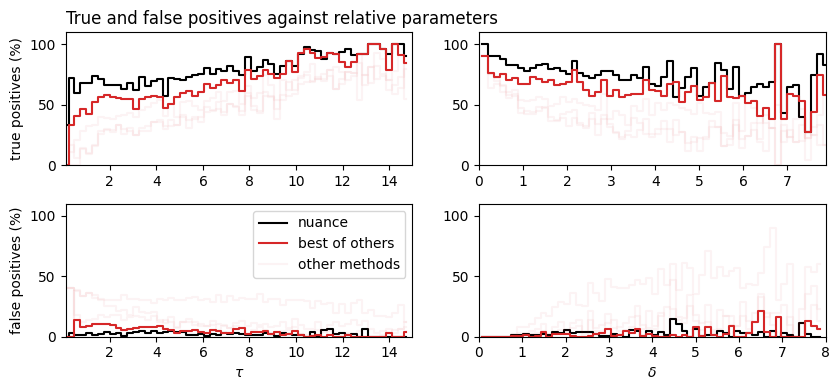

In [188]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8.5, 4))

tau_lim = 5
diff_color = "C3"

ax = plt.subplot(221)
plot("tau", ax, "tp")
plt.title("True and false positives against relative parameters", loc="left")
plt.ylabel("true positives (%)")
# plt.axvline(tau_lim, c="k", alpha=0.5)


ax = plt.subplot(222)
plot("delta", ax, "tp")
plt.ylim(0,110)
plt.xlim(bins["delta"][0], bins["delta"][-2])


ax = plt.subplot(223)
plot("tau", ax, "fp")
plt.xlabel(r"$\tau$")
plt.ylabel("false positives (%)")
plt.legend(loc="upper right")
# plt.axvline(tau_lim, c="k", alpha=0.5)

ax = plt.subplot(224)
plot("delta", ax, "fp")
plt.xlabel(r"$\delta$")
plt.ylim(0,110)


plt.tight_layout()
plt.savefig("../figures/true_false_positives.pdf")

In [171]:
main_method = "nuance"
other_methods = [method for method in methods if method != main_method]

# 1. When is nuance better that others in terms of true positives?
others_true_positives = np.max([true_positives[method] for method in other_methods], 0)
nuance_better_true_positives = true_positives[main_method].sum(1) >= others_true_positives.sum(1)
print("1.", 100*np.mean(nuance_better_true_positives))

# When is nuance better that others in terms of false positives?
others_false_positives = np.min([false_positives[method] for method in other_methods], 0)
nuance_better_false_positives = false_positives[main_method].sum(1) <= others_false_positives.sum(1)
print("2.", 100*np.mean(nuance_better_false_positives))

# 3. Both
nuance_better_overall = np.logical_and(nuance_better_true_positives, nuance_better_false_positives) 
print("3.", 100*np.mean(nuance_better_overall))

1. 79.45205479452055
2. 71.91780821917808
3. 55.70776255707762


In [172]:
# RESTRICTED TO TAU < tau_lim
mask = tau < tau_lim

# 1. When is nuance better that others in terms of true positives?
nuance_better_true_positives = true_positives[main_method][mask] >= others_true_positives[mask]
print("1.", 100*np.mean(nuance_better_true_positives))

# # When is nuance better that others in terms of false positives?
nuance_better_false_positives = false_positives[main_method][mask] <= others_false_positives[mask]
print("2.", 100*np.mean(nuance_better_false_positives))

# 3. Both
nuance_better_overall = np.logical_and(nuance_better_true_positives, nuance_better_false_positives) 
print("3.", 100*np.mean(nuance_better_overall))

1. 96.82281059063136
2. 97.27087576374745
3. 94.09368635437882


In [173]:
a = []
b = []

mask = tau < 5
for method in methods:
    detected = (true_positives[method] & detectable).sum() / detectable.sum()
    detected_restricted = (true_positives[method] & detectable)[mask].sum() / detectable[mask].sum()
    print(method, f"{100*detected:.2f}%", "-", f"{100*detected_restricted:.2f}%")
    a.append(true_positives[method].sum() / detectable.sum())
print()

for method in methods:
    extra_detection = ((value(method, "snr") >= snr_limit) & ~detectable).sum() / (~detectable).sum()
    extra_detection_restricted = ((value(method, "snr") >= snr_limit) & ~detectable)[mask].sum() / (~detectable)[mask].sum()
    print(method, f"{100*extra_detection:.2f}%", "-", f"{100*extra_detection_restricted:.2f}%")
    b.append(false_positives[method].sum() / detectable.sum())

bls_bspline 42.89% - 27.13%
bls_wotan3D 41.89% - 28.15%
bls_harmonics 64.87% - 52.67%
bens 52.64% - 41.75%
nuance 76.21% - 67.52%

bls_bspline 83.74% - 82.02%
bls_wotan3D 37.34% - 58.62%
bls_harmonics 34.40% - 40.48%
bens 16.16% - 21.28%
nuance 6.93% - 8.09%


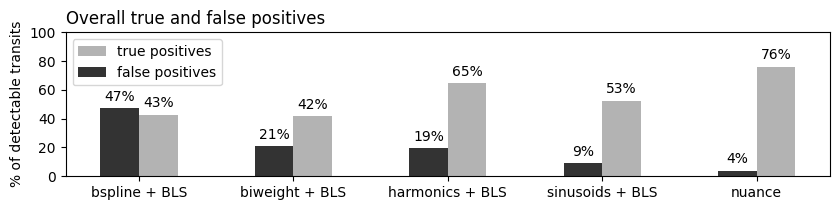

In [184]:
plt.figure(figsize=(8.5, 2.2))
x = 8*np.arange(len(a)); w=2
plt.bar(x + w/2, 100*np.array(a), w, label="true positives", color="0.7")
plt.bar(x - w/2, 100*np.array(b), w, color="0.2", label="false positives")
for i, (a_, b_) in enumerate(zip(a, b)):
    plt.text(x[i] + w/2, 100*a_+5, f"{100*a_:.0f}%", ha="center", fontsize=10)
    plt.text(x[i] - w/2, 100*b_+5, f"{100*b_:.0f}%", ha="center", fontsize=10)
    
plt.xticks(x, [methods[m] for m in methods])
plt.legend(loc="upper left")
plt.ylabel("% of detectable transits")
plt.ylim(0,100)
plt.title("Overall true and false positives", loc="left")
plt.tight_layout()
plt.savefig("../figures/true_and_false_positives_bars.pdf")

## Other plots

In [93]:
found_snr = defaultdict(list)
tp = defaultdict(list)

for method, result in all_.items():
    for i in range(len(all_[method])):
        found_snr[method].append(result[i]["delta"].values)

for method, result in all_.items():
    _true_positives = np.array(period_ok[method]) > 0
    _false_positives = np.logical_and(~(np.array(period_ok[method])==1.), np.array(snr_exceed[method]))
    tp[method] = np.array(found_snr[method])[_true_positives]

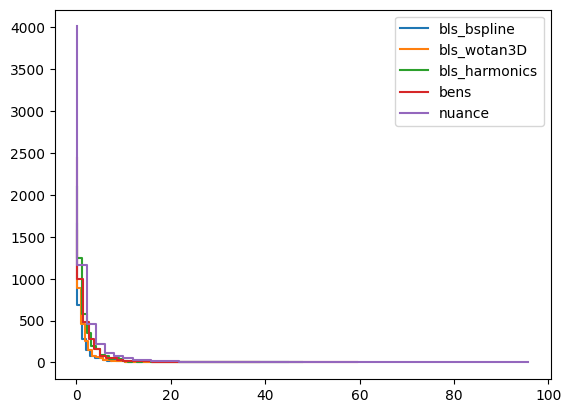

In [95]:
for method  in methods:
    a, b = np.histogram(tp[method], bins=50)
    _ = plt.step(b[0:-1], a, label=method)

plt.legend()
plt.xlim(2.5, 30)

In [44]:
_true_positives.shape

(438, 25)

In [41]:
found_snr["nuance"]

[array([ 4.7209077,  4.766569 ,  4.8163915,  4.798849 ,  4.791455 ,
         8.032319 ,  6.78976  ,  4.7229314,  4.792198 ,  5.101096 ,
        12.603717 ,  7.8432465,  6.254982 ,  6.642937 ,  6.2220063,
        13.999703 , 10.210186 ,  8.12027  ,  7.1934934,  7.6103015,
        18.220078 , 13.678719 , 12.113763 , 11.476896 ,  9.420686 ]),
 array([ 4.7723207,  4.653397 ,  4.781503 ,  4.657019 ,  4.704176 ,
         7.0007873,  4.646677 ,  4.739129 ,  4.701521 ,  4.6556435,
         8.541548 ,  7.866504 ,  5.4495535,  5.3486624,  4.7794924,
        12.875019 ,  7.4841814,  6.4698787,  6.1639824,  5.5369062,
        16.56176  ,  8.244756 ,  9.096315 ,  8.182723 ,  4.6352735]),
 array([ 4.743877 ,  4.7443814,  5.0424056,  4.7196875,  4.851232 ,
         5.4377327,  4.6211605,  5.006541 ,  5.043703 ,  4.759665 ,
         6.2324157,  8.755108 ,  7.899804 ,  6.2012916,  6.026664 ,
         7.4942527, 10.601234 ,  9.522255 ,  9.446908 ,  9.613761 ,
         8.970704 , 14.320828 , 13.642887 , 

In [28]:
period_ok["nuance"]

[[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0.5, 1, 0, 0, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0.5, 1, 1, 1],
 [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
 [0,
  0,
  0,
  0,
  0,
  1,
  0.5,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0.5,
  1,
  1,
  1],
 [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 

In [24]:
_ = {}

for method, result in all_.items():
    for i in range(len(all_[method])):
        _[method].append([right_candidate(0, injected, 0, recovered) for injected, recovered in 
                    zip(result[i]["period"], result[i]["true_period"])])

array([0.42857143, 0.9047619 , 0.72727273, 0.69172932, 0.64423077,
       0.70526316, 0.72727273, 0.64583333, 0.65217391, 0.65053763,
       0.64566929, 0.67657993, 0.57920792, 0.68571429, 0.64215686,
       0.69527897, 0.66666667, 0.59649123, 0.66666667, 0.66836735,
       0.71689498, 0.70899471, 0.72348485, 0.74576271, 0.80213904,
       0.72373541, 0.78645833, 0.76630435, 0.80645161, 0.78343949,
       0.77181208, 0.88073394, 0.81168831, 0.77777778, 0.86554622,
       0.86486486, 0.7654321 , 0.78313253, 0.87096774, 0.85555556,
       0.92553191, 0.93103448, 0.97647059, 0.94339623, 0.83333333,
       0.91304348, 0.97368421, 0.88679245, 0.97959184, 0.94444444,
       0.93333333, 1.        , 0.97435897, 1.        , 0.98      ,
       1.        , 1.        , 1.        , 1.        ])

In [362]:
detectable[method][0]

0     False
1     False
2     False
3     False
4     False
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
Name: true_snr, dtype: bool

In [339]:
np.array(detectable[method]).sum()

7823

In [333]:
np.sum(method_true_positives & ~others_true_positives)

811

In [316]:
method_true_positives.mean()

0.2789041095890411

In [301]:
np.mean([np.sum(nuance_true_positives[i] * mask[i]) >= np.sum(others_true_positives[i] * mask[i]) for i in range(len(tau))])

0.906392694063927

In [294]:
np.logical_and(np.array(period_ok[method]), np.array(snr_ok[method]))[mask]

array([False, False, False, ...,  True,  True,  True])

In [290]:
mask

array([[False,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False,  True],
       [False, False,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False,  True,  True]])

In [278]:
np.mean(nuance_true_positives.sum(1) >= others_true_positives.sum(1))

0.8356164383561644

In [270]:
np.mean(nuance_true_positives == np.max(other_true_positives, 0))

0.9000913242009132

In [256]:
np.max(other_true_positives, 0).mean()

0.488310502283105

TypeError: unhashable type: 'slice'

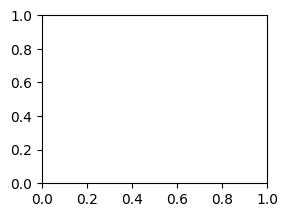

In [181]:
plt.subplot(221)

tau_lim = 5
plt.step(bins[0:-1], true_positives["tau"]["nuance"]*100, c="k")
other_methods = [method for method in methods if method != "nuance"]
others = np.max([true_positives_tau[method] for method in other_methods], 0)
plt.step(bins[0:-1], others*100, c="C3")
for method in other_methods:
    plt.step(bins[0:-1], true_positives["tau"][method]*100, c="C3", alpha=0.1)
plt.xlim(bins_tau[0], bins_tau[-2])
plt.ylim(0, 110)

plt.subplot(222)
plt.step(bins[0:-1], true_positives_tau["nuance"]*100, c="k")

In [119]:
np.histogram(tau, bins=bins)[0]

array([ 10,  30,  85, 185, 295, 265, 260, 270, 225, 260, 360, 375, 290,
       300, 290, 330, 310, 320, 335, 280, 315, 260, 375, 255, 265, 360,
       275, 255, 280, 225, 205, 155, 220, 180, 165, 155, 120, 115,  85,
       130, 130,  75, 110,  75,  70,  60,  50,  70,  65,  50,  20,  15,
        50,  35,  65,  30,  35,  15,  25])

In [118]:
np.histogram(tau[np.array(detectable[method])], bins=bins)[0]

array([  7,  21,  55, 133, 208, 190, 176, 192, 161, 186, 254, 269, 202,
       210, 204, 233, 222, 228, 240, 196, 219, 189, 264, 177, 187, 257,
       192, 184, 186, 157, 149, 109, 154, 126, 119, 111,  81,  83,  62,
        90,  94,  58,  85,  53,  54,  46,  38,  53,  49,  36,  15,  12,
        39,  28,  50,  24,  28,  11,  20])

In [116]:
np.array(detectable)

array(defaultdict(<class 'list'>, {'bls_bspline': [0     False
1     False
2     False
3     False
4     False
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
Name: true_snr, dtype: bool, 0     False
1     False
2     False
3     False
4     False
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
Name: true_snr, dtype: bool, 0     False
1     False
2     False
3     False
4     False
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24 

In [113]:
np.histogram(tau, bins=bins)[0]

array([ 10,  30,  85, 185, 295, 265, 260, 270, 225, 260, 360, 375, 290,
       300, 290, 330, 310, 320, 335, 280, 315, 260, 375, 255, 265, 360,
       275, 255, 280, 225, 205, 155, 220, 180, 165, 155, 120, 115,  85,
       130, 130,  75, 110,  75,  70,  60,  50,  70,  65,  50,  20,  15,
        50,  35,  65,  30,  35,  15,  25])

In [ ]:
np.array(detectable[method])

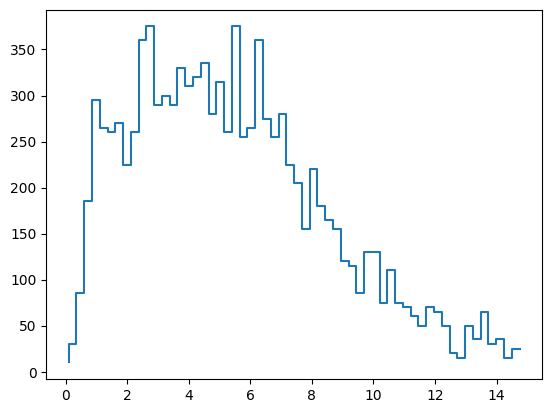

In [110]:
bins = np.linspace(0.1, 15, 60)
plt.step(bins[0:-1], np.histogram(tau, bins=bins)[0])

In [105]:
tp

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True,  True]])

In [103]:
period_ok[method]

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0],
 [0.5,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.5,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0],
 [0, 0, 0, 0, 0, 1, 0.5, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1],
 [0, 0, 0,

In [ ]:
result

(array([ 53., 216., 281., 234., 301., 304., 283., 339., 288., 292., 336.,
        330., 322., 286., 222., 217., 208., 142., 127., 152., 138.,  82.,
         84.,  78.,  38.,  69.,  71.,  35.,  47.,  66.,  28.,  31.,  35.,
         20.,  20.,  24.,  20.,  20.,   4.,   8.,   4.,   0.,   4.,   4.,
          0.,   4.,   0.,   0.,   0.,   8.]),
 array([ 0.2929904 ,  0.81589627,  1.33880213,  1.86170799,  2.38461385,
         2.90751972,  3.43042558,  3.95333144,  4.4762373 ,  4.99914316,
         5.52204903,  6.04495489,  6.56786075,  7.09076661,  7.61367248,
         8.13657834,  8.6594842 ,  9.18239006,  9.70529593, 10.22820179,
        10.75110765, 11.27401351, 11.79691938, 12.31982524, 12.8427311 ,
        13.36563696, 13.88854283, 14.41144869, 14.93435455, 15.45726041,
        15.98016628, 16.50307214, 17.025978  , 17.54888386, 18.07178973,
        18.59469559, 19.11760145, 19.64050731, 20.16341317, 20.68631904,
        21.2092249 , 21.73213076, 22.25503662, 22.77794249, 23.30084835,
 

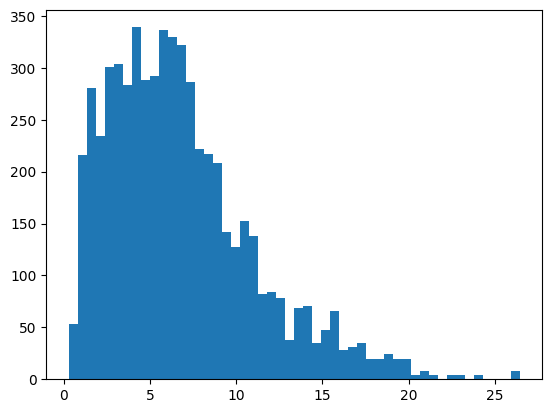

In [92]:
import matplotlib.pyplot as plt

plt.hist(tau[tp], bins=50)

In [83]:
tp = np.logical_and(np.array(period_ok[method]), np.array(snr_ok[method]))

,t0,period,true_t0,true_period,found,radius,tau,delta,fresh_snr,snr,true_snr
0,2.960000,3.658140,0.219525,0.40,False,1.638724,6.466591,4.319716,4.732696,4.720908,2.219728
1,0.210000,2.455139,0.646384,1.55,False,1.638724,4.117037,4.319716,4.732696,4.766569,2.535291
2,0.200000,2.460840,1.177186,2.70,False,1.638724,3.421691,4.319716,4.732696,4.816391,2.533332
3,0.393567,1.574269,2.120572,3.85,False,1.638724,3.040011,4.319716,4.732696,4.798849,2.940087
4,0.393567,1.574269,4.835149,5.00,False,1.638724,2.786369,4.319716,4.732696,4.791455,2.940087
5,0.493722,0.399775,0.088797,0.40,True,2.270576,6.466591,2.250063,4.732696,8.032319,8.913368
6,1.386008,1.548612,1.383933,1.55,True,2.270576,4.117037,2.250063,4.732696,6.789760,5.675439
7,0.200000,2.460840,0.206032,2.70,False,2.270576,3.421691,2.250063,4.732696,4.722931,4.863541
8,0.210000,2.453713,3.362703,3.85,False,2.270576,3.040011,2.250063,4.732696,4.792198,4.868245
9,0.210000,2.453713,0.051871,5.00,False,2.270576,2.786369,2.250063,4.732696,5.101096,4.868245


In [55]:
period_ok

defaultdict(list,
            {'bls_bspline': [0,
              0,
              0,
              0,
              0,
              1,
              0,
              0,
              0,
              0,
              1,
              0,
              0.5,
              0,
              0,
              1,
              1,
              0,
              0,
              0,
              1,
              1,
              1,
              0,
              0],
             'bls_wotan3D': [0,
              0,
              0,
              0,
              0,
              1,
              0,
              0,
              0,
              0,
              1,
              1,
              0,
              0,
              0,
              1,
              1,
              1,
              1,
              0,
              1,
              1,
              1,
              0,
              0],
             'bls_harmonics': [0,
              0,
              0,
              0,
             

In [52]:
len(all_["nuance"])

438

In [48]:
all_["nuance"][:, :, 0]

array([[2.96, 0.21, 0.2, ..., 0.56, 1.99, 4.8],
       [3.03, 0.582330832708177, 1.19, ..., 0.56, 1.99, 1.19],
       [1.773944111027757, 3.12, 3.1100000000000003, ..., 0.56, 1.99,
        4.8],
       ...,
       [3.95, 3.95, 3.95, ..., 0.57, 1.99, 4.8],
       [0.95, 0.7220498874718679, 0.5576736684171042, ..., 0.56, 1.99,
        4.800000000000001],
       [2.5083949737434357, 2.515927606901726, 2.9203548387096774, ...,
        0.56, 1.99, 4.800000000000001]], dtype=object)

In [40]:
all_["nuance"][0]

array([[2.96, 3.6581395348837207, 0.2195254015709299, 0.4, False,
        1.6387237781360258, 6.466590656238017, 4.319716358979049,
        4.732695836764654, 4.7209077, 2.219727981401609],
       [0.21, 2.4551387846961736, 0.6463841072889897, 1.5499999999999998,
        False, 1.6387237781360258, 4.11703729779789, 4.319716358979049,
        4.732695836764654, 4.766569, 2.535291089279395],
       [0.2, 2.460840210052513, 1.17718623578341, 2.6999999999999997,
        False, 1.6387237781360258, 3.4216909367866517, 4.319716358979049,
        4.732695836764654, 4.8163915, 2.5333316026416703],
       [0.3935671417854464, 1.5742685671417855, 2.1205719249121153, 3.85,
        False, 1.6387237781360258, 3.040010784923815, 4.319716358979049,
        4.732695836764654, 4.798849, 2.940087378248794],
       [0.3935671417854464, 1.5742685671417855, 4.835149195068383, 5.0,
        False, 1.6387237781360258, 2.786369447207045, 4.319716358979049,
        4.732695836764654, 4.791455, 2.940087378248794]

In [45]:
all_["nuance"][0, :, 1]

array([3.6581395348837207, 2.4551387846961736, 2.460840210052513,
       1.5742685671417855, 1.5742685671417855, 0.399774943735934,
       1.5486121530382595, 2.460840210052513, 2.453713428357089,
       2.453713428357089, 0.399774943735934, 1.5500375093773444,
       2.703150787696924, 3.857689422355589, 2.453713428357089,
       0.399774943735934, 1.551462865716429, 2.6988747186796695,
       3.8534133533383343, 4.993698424606151, 0.399774943735934,
       1.5486121530382595, 2.7017254313578394, 3.8519879969992497,
       5.000825206301575], dtype=object)

In [44]:
all_["nuance"][0, :, 3]

array([0.4, 1.5499999999999998, 2.6999999999999997, 3.85, 5.0, 0.4,
       1.5499999999999998, 2.6999999999999997, 3.85, 5.0, 0.4,
       1.5499999999999998, 2.6999999999999997, 3.85, 5.0, 0.4,
       1.5499999999999998, 2.6999999999999997, 3.85, 5.0, 0.4,
       1.5499999999999998, 2.6999999999999997, 3.85, 5.0], dtype=object)

In [28]:
all_["nuance"].shape

(438, 25, 10)

In [3]:
has_best_tp = np.all(per_target_true_positives[:, -1][:, None] >= per_target_true_positives[:, 0:-1], axis=1)
has_best_fp = np.all(per_target_false_positives[:, -1][:, None] <= per_target_false_positives[:, 0:-1], axis=1)

In [5]:
has_best_tp.mean(), has_best_fp.mean(), (has_best_tp & has_best_fp).mean()

(0.8904109589041096, 0.6963470319634704, 0.6598173515981736)

In [9]:
mask = true_positives['bens'][0] < 5



array([False,  True,  True, ..., False,  True,  True])

In [ ]:

has_best_tp.mean(), has_best_fp.mean(), (has_best_tp & has_best_fp).mean()

In [99]:
per_target_true_positives = np.array(per_target_true_positives)

In [64]:
np.mean([true_positives[method][2]] for method in methods)

TypeError: unsupported operand type(s) for /: 'generator' and 'int'

In [63]:
true_positives["nuance"][1]

array([[6.46659066, 4.1170373 , 3.42169094, ..., 5.26284852, 4.67579234,
        4.28567062],
       [4.31971636, 4.31971636, 4.31971636, ..., 0.83002733, 0.83002733,
        0.83002733],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

/var/folders/wn/j_ytm31108z7jt5f1x0d7j1c0000gq/T/ipykernel_29606/456105254.py:7: RuntimeWarning: invalid value encountered in divide
  nuance = np.histogram(true_positives["nuance"][:, true_positives["nuance"][2] == 1.][i], bins=bins)[0]/total
/var/folders/wn/j_ytm31108z7jt5f1x0d7j1c0000gq/T/ipykernel_29606/456105254.py:8: RuntimeWarning: invalid value encountered in divide
  others = [np.histogram(true_positives[method][:, true_positives[method][2] == 1.][i], bins=bins, density=False)[0] for method in methods if method != "nuance"]/total
/var/folders/wn/j_ytm31108z7jt5f1x0d7j1c0000gq/T/ipykernel_29606/456105254.py:51: RuntimeWarning: invalid value encountered in divide
  nuance = np.histogram(false_positives["nuance"][:, false_positives["nuance"][2] == 1.][i], bins=bins)[0]/total
/var/folders/wn/j_ytm31108z7jt5f1x0d7j1c0000gq/T/ipykernel_29606/456105254.py:52: RuntimeWarning: invalid value encountered in divide
  others = [np.histogram(false_positives[method][:, false_positives[method

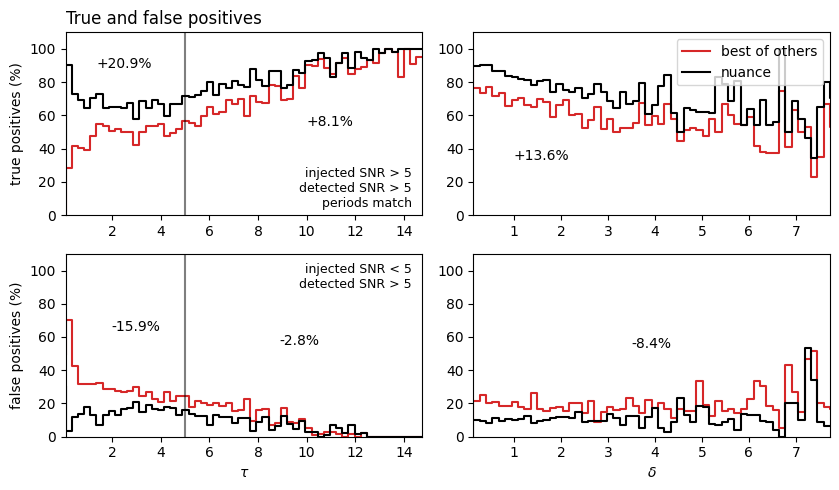

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8.5, 5))

def plot(i, bins, legend=False):
    total = np.histogram(true_positives["nuance"][i][true_positives["nuance"][-1].astype(bool)], bins=bins)[0]
    nuance = np.histogram(true_positives["nuance"][:, true_positives["nuance"][2] == 1.][i], bins=bins)[0]/total
    others = [np.histogram(true_positives[method][:, true_positives[method][2] == 1.][i], bins=bins, density=False)[0] for method in methods if method != "nuance"]/total
    others_max = np.max(others, axis=0)
    plt.step(bins[0:-1], others_max*100, c="C3", label="best of others" if legend else None)
    plt.step(bins[0:-1], nuance*100, c="k", label="nuance" if legend else None)
    # plt.step(bins[0:-1], (nuance-others_max)*100, c=diff_color, label="difference" if legend else None)
    # plt.fill_between(bins[0:-1], 0, (nuance-others_max)*100, step="pre", color=diff_color, alpha=0.2)
    return nuance, others_max

n = 60
text_y_pos = 0.2
diff_color = "k"
tau_lim = 5
tau_bins = np.linspace(0.1, 15, n)

###
plt.subplot(221)
plt.title("True and false positives", loc="left")

nuance, others_max = plot(0, tau_bins)
# plt.xlabel(r"$\tau$")
plt.ylabel("true positives (%)")
plt.ylim(0,110)
plt.xlim(tau_bins[0], tau_bins[-2])
plt.axvline(tau_lim, c=diff_color, alpha=0.5)
mask = tau_bins[:-1] < tau_lim
plt.text(2.5, 95 , f"+{np.nanmean((nuance-others_max)[mask])*100:.1f}%", va="top", ha="center", color=diff_color)
plt.text(10, 60, f"+{np.nanmean((nuance-others_max)[~mask])*100:.1f}%", va="top", ha="left", color=diff_color)
plt.text(0.97, 0.03, f"injected SNR > {snr_limit}\n detected SNR > {snr_limit}\nperiods match", va="bottom", ha="right", color=diff_color, transform=plt.gca().transAxes, fontsize=9)

plt.subplot(222)
bins = np.linspace(0, 8, n)
nuance, others_max = plot(1, bins, legend=True)
# plt.xlabel(r"$\delta$")
plt.legend()
plt.ylim(0,110)
plt.xlim(bins[1], bins[-3])
plt.tight_layout()
plt.text(1, 40, f"+{np.nanmean((nuance-others_max))*100:.1f}%", va="top", ha="left", color=diff_color)
plt.legend(loc="upper right")


def plot(i, bins):
    total = np.histogram(false_positives["nuance"][i], bins=bins)[0]
    nuance = np.histogram(false_positives["nuance"][:, false_positives["nuance"][2] == 1.][i], bins=bins)[0]/total
    others = [np.histogram(false_positives[method][:, false_positives[method][2] == 1.][i], bins=bins, density=False)[0] for method in methods if method != "nuance"]/total
    others_min = np.min(others, axis=0)
    plt.step(bins[0:-1], others_min*100, c="C3", label=None)
    plt.step(bins[0:-1], nuance*100, c="k", label=None)
    # plt.step(bins[0:-1], -(nuance-others_max)*100, c=diff_color)
    # plt.fill_between(bins[0:-1], 0, -(nuance-others_max)*100, step="pre", color=diff_color, alpha=0.2)
    return nuance, others_min

text_y_pos = 0.8

###
plt.subplot(223)
nuance, others_max = plot(0, tau_bins)
plt.xlabel(r"$\tau$")
plt.ylabel("false positives (%)")
plt.ylim(0,110)
plt.xlim(tau_bins[0], tau_bins[-2])
plt.axvline(tau_lim, c=diff_color, alpha=0.5)
mask = tau_bins[:-1] < tau_lim
plt.text(3, 70, f"{np.nanmean((nuance-others_max)[mask])*100:.1f}%", va="top", ha="center", color=diff_color)
plt.text(0.6, text_y_pos*0.7, f"{np.nanmean((nuance-others_max)[~mask])*100:.1f}%", transform=plt.gca().transAxes, va="top", ha="left", color=diff_color)
plt.text(0.97, 0.95, f"injected SNR < {snr_limit}\n detected SNR > {snr_limit}", va="top", ha="right", color=diff_color, transform=plt.gca().transAxes, fontsize=9)

plt.subplot(224)
bins = np.linspace(0, 8, n)
nuance, others_max = plot(1, bins)
plt.xlabel(r"$\delta$")
plt.ylim(0,110)
plt.xlim(bins[1], bins[-3])
plt.text(3.5, 60, f"{np.nanmean((nuance-others_max))*100:.1f}%", va="top", ha="left", color=diff_color)

plt.tight_layout()
plt.savefig("../figures/true_false_positive.pdf")

In [76]:
mask = (true_positives["nuance"][0] < 6) & (true_positives["nuance"][1] < 8)
(true_positives["nuance"][-1]) - np.mean(np.max([true_positives[method][-1] for method in methods if method != "nuance"]))


IndexError: invalid index to scalar variable.

In [81]:
(true_positives["nuance"][-1]) - np.mean(np.max([true_positives[method][-1] for method in methods if method != "nuance"])).shape

ValueError: operands could not be broadcast together with shapes (11075,) (0,) 

In [75]:
np.hstack(true_positives["nuance"][-1]) - np.mean(np.max([true_positives[method][-1] for method in methods if method != "nuance"]))

array([ 0.,  0., -1., ...,  0.,  0.,  0.])

In [79]:
(true_positives["nuance"][-1]) - np.mean(np.max([true_positives[method][-1] for method in methods if method != "nuance"]))[mask]

IndexError: invalid index to scalar variable.

In [78]:
[mask]

[array([False,  True,  True, ...,  True,  True,  True])]

In [68]:
true_positives["bens"]

array([[6.46659066, 3.38046173, 2.75017873, ..., 4.23000626, 3.72738507,
        3.40153903],
       [2.57089382, 2.57089382, 2.57089382, ..., 0.41736812, 0.41736812,
        0.41736812],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [67]:
true_positives["nuance"]

array([[6.46659066, 3.38046173, 2.75017873, ..., 4.23000626, 3.72738507,
        3.40153903],
       [2.57089382, 2.57089382, 2.57089382, ..., 0.41736812, 0.41736812,
        0.41736812],
       [1.        , 1.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [66]:
np.mean(np.max([false_positives[method][-1] for method in methods if method != "nuance"], 0)) - np.mean(false_positives["nuance"][-1])

0.468352144469526